In [1]:
import os
import datetime

import numpy as np
import pandas as pd
import rasterio as rio
import geopandas as gp

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

from rasterio.mask import mask
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.lines import Line2D      
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

In [2]:
# Helpers

# compute annual means (except 2017 due to some funky values outside of our study area )
def chunks(r,n):
    for i in range (0,len(r),n):
        yield r[i:i+n]

def process_chunks(chunks, scale_factor = None):

    fnarrs = []

    for fn in chunks:
        src = rio.open(fn)
        arr = src.read(1).astype(np.float64) 
        arr[arr== -9999.] = np.nan
        arr = arr/scale_factor
        fnarrs.append(arr)

    stacked_arrs = np.dstack(fnarrs)

    msum = np.nansum(stacked_arrs, axis = 2)

    return msum


def calc_annual_medians(var_files, scale_factor = None):
    
    # Full years only 
    years = range(2004,2022)
    months = range(1,13)

    ann_means = []

    for year in tqdm(list(years)):

        m_sums = []
        year = str(year)
        for month in list(months):
            if len(str(month)) == 1:
                month = str(month).zfill(2)

            ymstr = str(year)+ str(month)
            month_files = [x for x in var_files if ymstr in x]
            monthly_sum = process_chunks(month_files,scale_factor=scale_factor)
            m_sums.append(monthly_sum)

        yearstack = np.dstack(m_sums)
        yearsum = np.nansum(yearstack, axis = 2)
        ann_means.append(yearsum)

    return np.nanmedian(np.dstack(ann_means), axis = 2)



def plot_basemaps(image, shp, title = None, cmap = 'viridis', ax = None, latlabels = True, lonlabels = True, vmax = None):
    imextent = gp.read_file(shp).set_crs("EPSG:4326").to_crs(4326).bounds
    shape_feature = ShapelyFeature(Reader("../shape/sierra_catchments.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='white', facecolor = 'none')


    lllon, lllat = imextent.minx.values[0], imextent.miny.values[0]
    urlon, urlat = imextent.maxx.values[0], imextent.maxy.values[0]

    # Create a Stamen Terrain instance.
    stamen_terrain = cimgt.Stamen('terrain-background')

    # Create a GeoAxes in the tile's projection.
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels= False
    gl.right_labels = False
    if not latlabels:
        gl.left_labels = False
    if not lonlabels:
        gl.bottom_labels = False
        
    gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,361))
    gl.ylocator = mticker.FixedLocator(np.linspace(0,90,91))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 9, 'color': 'gray'}
    gl.ylabel_style = {'size': 9, 'color': 'gray'}

    # Limit the extent of the map to a small longitude/latitude range.
    ax.set_extent([lllon, urlon, lllat, urlat])

    # Add the Stamen data at zoom level 8.
    ax.add_image(stamen_terrain, 8)
    
    im = ax.imshow(image,
        cmap=cmap, zorder=1, vmin = 0, vmax = vmax,
        origin="upper", alpha = 0.8,
        extent=(lllon, urlon, lllat, urlat),
        transform=ccrs.PlateCarree(),
    )

    # Add shapefile outline
    ax.add_feature(shape_feature, zorder = 2)
    
    # Set the title
    ax.set_title("{}".format(title), size = 12)
    
    cbar = plt.colorbar(mappable=im,orientation='vertical', fraction=0.05, pad = 0.0125, ax = ax)
    return 



In [3]:
# Setup dirs 
smlt_dir = "../data/SMLT/"
prcp_dir = "../data/PLQD/"

# Get lists of files 
smlt_files = [os.path.join(smlt_dir,x) for x in os.listdir(smlt_dir) if x.endswith(".tif")]
prcp_files = [os.path.join(prcp_dir,x) for x in os.listdir(prcp_dir) if x.endswith(".tif")]

# Sort
smlt_files.sort()
prcp_files.sort()

In [4]:
# Calc the annual averages
ann_avg_smlt = calc_annual_medians(smlt_files, scale_factor = 100000)
ann_avg_prcp = calc_annual_medians(prcp_files, scale_factor = 10)


100%|██████████| 18/18 [06:58<00:00, 23.26s/it]


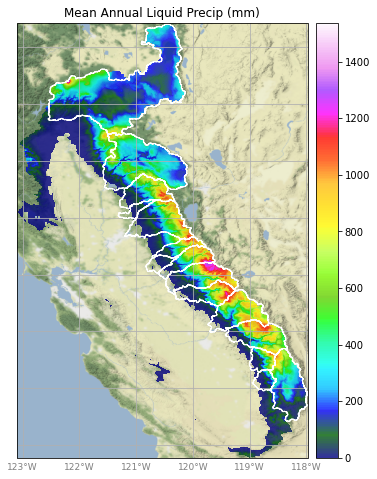

In [5]:
# Plot Precip
outlets = gp.read_file("../shape/term_res.shp")
fig, axes = plt.subplots(nrows=1, ncols=1,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
plot_basemaps(np.where(ann_avg_prcp==0,np.nan,ann_avg_prcp), "../shape/cvws.shp", "Mean Annual Liquid Precip (mm)", cmap = 'gist_ncar', ax = axes, latlabels = False, lonlabels = True )
# outlets.plot(ax = axes, color = 'black', markersize = 75, edgecolor = 'orange', zorder = 4)

plt.show()

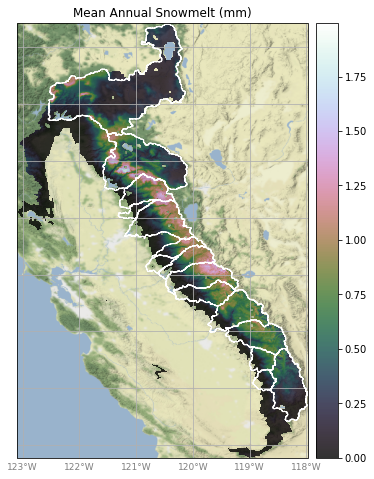

In [6]:
# Plot snowmelt
fig, axes = plt.subplots(nrows=1, ncols=1,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
plot_basemaps(np.where(ann_avg_smlt==0,np.nan,ann_avg_smlt), "../shape/cvws.shp", "Mean Annual Snowmelt (mm)", cmap = 'cubehelix', ax = axes, latlabels = False, lonlabels = True)
# outlets.plot(ax = axes, color = 'black', markersize = 75, edgecolor = 'orange', zorder = 4)

plt.show()

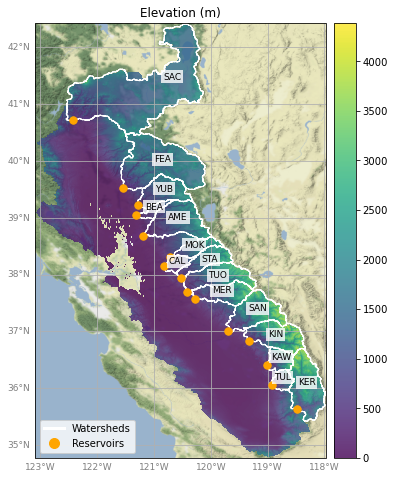

In [7]:
# Read elevation
esrc = rio.open("../data/SRTM/dem_masked.tif")
earr = esrc.read(1).astype(float)
earr[earr==0] = np.nan

# Plot Elevation
fig, axes = plt.subplots(nrows=1, ncols=1,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
ax1 = plot_basemaps(earr, "../shape/cvws.shp", "Elevation (m)", cmap = 'viridis', ax = axes, latlabels = True, lonlabels = True )
outlets.plot(ax = axes, color = 'orange', markersize = 55, edgecolor = 'orange', zorder = 4)

# Get some coords for shed labels
catchments = gp.read_file("../shape/sierra_catchments.shp")
c = catchments.copy()
c['coords'] = c['geometry'].apply(lambda x: x.representative_point().coords[:])
c['coords'] = [coords[0] for coords in c['coords']]

# Label the sheds
for idx, row in c.iterrows():
    axes.text(row.coords[0], row.coords[1], s=row['catch_name'][:3], horizontalalignment='center', size = 9,
    bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'}, zorder= 5)

    
shed_patch = Line2D([0],[0],color='white',label='Watersheds', lw=3)
# res_patch = mpatches.Circle(color='black',edgecolor = 'orange', label='Reservoirs')
res_patch = Line2D([0],[0],marker='o',markersize=10,color='orange', markeredgecolor = 'orange',label='Reservoirs', lw=0)

plt.legend(handles=[shed_patch, res_patch], loc = 'lower left')
plt.show()

In [8]:
# Get reservoir inflow
            
def get_res_data(stid, startdate, enddate, freq = 'D', var = 'inflow'):
    '''
    Fetch CDEV reservoir data via api 
    Input Params: 
        stid (str) - 3 letter station id (ex: ISB)
        startdate - 'YYYY-mm-dd'
        startdate - 'YYYY-mm-dd'
        freq - "D" = Day, "M" = Month
    
    Output: inflow - (pd.DataFrame)
    '''
    varlookup = {
                    'storage':'65',
                    'inflow':'76'}
    
    # build the api query from params
    query = '''https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations={}&SensorNums={}&dur_code={}&Start={}&End={}'''.format(stid,varlookup[var],freq,startdate,enddate)
    print(query)
    # Read, extract relevant cols as float and datetime, return df
    dat = pd.read_csv(query)
    vals_cfs = pd.to_numeric(dat['VALUE'], errors = 'coerce')
    # cubic ft / sec --> cubic m / day 
    vals_cmd = abs(vals_cfs) * 0.0283168 * 86400
    dt = pd.to_datetime(dat['DATE TIME'])
    indf = pd.DataFrame(zip(dt,vals_cmd), columns = ['date',"q_cmd"]) # cfs --> CMS 
    indf.set_index(indf.columns[0], inplace = True)
    return indf

In [9]:
# Don't process if already exists 

In [10]:
if not os.path.exists("../data/CDEC/runoff.csv"):
    # Datetime the start/end
    start = datetime.datetime.strptime("2003-10-01", "%Y-%m-%d")
    end = datetime.datetime.strptime("2021-09-30", "%Y-%m-%d")
    dt_idx = pd.date_range(start,end, freq='D')

    # Datetime objs --> strs
    d1strs = [x.strftime('%Y-%m-%d') for x in dt_idx]

    # Read catchments 
    gdf = gp.read_file("../shape/sierra_catchments.shp")
    stn_lookup = dict(zip(gdf['stid'], [x[:3] for x in gdf['catch_name']]))

    # Get the inflow
    runoff_cmd = {}
    runoff_mm = {}

    for stn_id in tqdm(list(gdf['stid'])):
        # get runoff in cubic m / day
        rdf = get_res_data(stn_id, d1strs[0], d1strs[-1])
        # convert to units of mm by dividing by watershed area
        area_m2 = gdf[gdf['stid'] == stn_id]['area_km2'] * 1e6
        rdf_mm = rdf/area_m2.values[0] * 1e3

        runoff_cmd[stn_id]  = rdf
        runoff_mm[stn_id]  = rdf_mm

    # Concat dfs
    rdf = pd.concat(runoff_mm, axis=1)
    rdf.columns = rdf.columns.droplevel(-1)
    
else:
    rdf = pd.read_csv("../data/CDEC/runoff.csv")
    rdf['date'] = pd.to_datetime(rdf['date'])
    rdf.set_index("date", inplace = True)    

<ipython-input-11-85aa9e1a6e41>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 60, fontsize = 11)


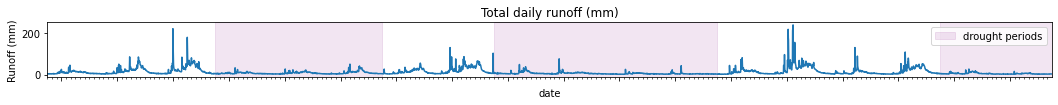

In [11]:
# Timeseries of cumulative runof
plt.figure(figsize = (18,1))
ax = rdf.sum(axis = 1).plot(label='_nolegend_')
ax.set_title("Total daily runoff (mm)")
ax.set_ylabel("Runoff (mm)")

ax.set_xticklabels(ax.get_xticklabels(),rotation = 60, fontsize = 11)
ax.xaxis.set_major_locator(mdates.YearLocator())# Major ticks every year.
ax.xaxis.set_minor_locator(mdates.MonthLocator()) # Minor ticks every month.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))# Text in the x axis will be displayed in 'YYYY' format.

ax.set(xticklabels=[])  # remove the tick labels

# Shade droughts 
plt.axvspan('2006-10-01', '2009-10-01', alpha=0.1, color='purple', label = 'drought periods')
plt.axvspan('2011-10-01', '2015-10-01', alpha=0.1, color='purple')
plt.axvspan('2019-10-01', '2021-10-01', alpha=0.1, color='purple')

plt.legend(bbox_to_anchor=[1, 1], loc='upper right')
plt.show()

In [12]:
stn_lookup = dict(zip(list(catchments['stid']), list([x[:3] for x in catchments['catch_name']])))

In [13]:
# Count the # of CONSECUTIVE nans per col 

In [14]:
for col in rdf.columns:
    data = rdf[col]
    na_groups = data.notna().cumsum()[data.isna()]
    lengths_consecutive_na = na_groups.groupby(na_groups).agg(len)
    longest_na_gap = lengths_consecutive_na.max()
    print(stn_lookup[col], longest_na_gap)

YUB nan
MOK 1726
SAN nan
KER nan
TUO nan
STA nan
FEA nan
AME nan
KAW nan
TUL nan
BEA 6575
KIN nan
MER 6575
CAL nan
SAC nan


In [15]:
# Count the number of nans per col
rdf.isna().sum()

ENG       0
PAR    1726
MIL       0
ISB       0
DNP       0
NML       0
ORO       0
FOL       0
TRM       0
SCC       0
CFW    6575
PNF       0
MCR    6575
NHG       0
SHA       0
dtype: int64

In [16]:
# polynomial interpolate the nans 

outdf = rdf.interpolate(method='polynomial', order=3)

# Check that the vals are filled after interpolation
for col in outdf.columns:
    data = outdf[col]
    na_groups = data.notna().cumsum()[data.isna()]
    lengths_consecutive_na = na_groups.groupby(na_groups).agg(len)
    longest_na_gap = lengths_consecutive_na.max()
    print(stn_lookup[col], longest_na_gap)
    
# If doesn't exist, save
if not os.path.exists("../data/CDEC/runoff.csv"):
    outdf.to_csv("../data/CDEC/runoff.csv")

YUB nan
MOK 1726
SAN nan
KER nan
TUO nan
STA nan
FEA nan
AME nan
KAW nan
TUL nan
BEA 6575
KIN nan
MER 6575
CAL nan
SAC nan


In [17]:
# Now extract the sums at each time slice

In [18]:
# Make a blank array for the dates that don't exist 
ref_src = rio.open(smlt_files[0])
ref_arr = np.zeros_like(ref_src.read(1))
ref_arr = np.where(ref_arr==0, np.nan, ref_arr)

def read_as_array(fn, scale_factor):
    
    src = rio.open(fn)
    arr = src.read(1).astype(float) 
    arr[arr== -9999.] = np.nan
    arr = arr/scale_factor
    return arr

In [19]:
# Datetime the start/end
start = datetime.datetime.strptime("2003-10-01", "%Y-%m-%d")
end = datetime.datetime.strptime("2021-09-30", "%Y-%m-%d")
dt_idx = pd.date_range(start,end, freq='D')

# Find missing dates 
d1strs = [x.strftime('%Y%m%d') for x in dt_idx]

smlt_arrs = {}
prcp_arrs = {}

for datestr in tqdm(d1strs[:]):
    
    smlt_fn = [x for x in smlt_files if datestr in x]
    prcp_fn = [x for x in prcp_files if datestr in x]
    
    # Add nan ims for the dates with no data (listed in SI)
    if len(smlt_fn) == 0:
        smlt_arr = ref_arr.copy()
    else:
        smlt_arr = read_as_array(smlt_fn[0], scale_factor= 100000)
    
    if len(prcp_fn) == 0:
        prcp_arr = ref_arr.copy()
    else:
        prcp_arr = read_as_array(prcp_fn[0], scale_factor= 10)
        
    # drop zeros from arrays (throws off the averaging)
    smlt_arr_filt = np.where(smlt_arr==0, np.nan, smlt_arr)
    npix = np.count_nonzero(smlt_arr_filt)
    
#     smlt_arr[smlt_arr==0] = np.nan
#     prcp_arr[prcp_arr==0] = np.nan
    
    # Add to dicts 
    smlt_arrs[datestr] = np.nansum(smlt_arr_filt) / npix
    prcp_arrs[datestr] = np.nanmean(prcp_arr)

  2%|▏         | 147/6575 [00:17<10:38, 10.07it/s]<ipython-input-19-e94d9f372489>:37: RuntimeWarning: Mean of empty slice
  prcp_arrs[datestr] = np.nanmean(prcp_arr)
100%|██████████| 6575/6575 [17:42<00:00,  6.19it/s]  


<ipython-input-20-db69ee2b4d76>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 60, fontsize = 11)


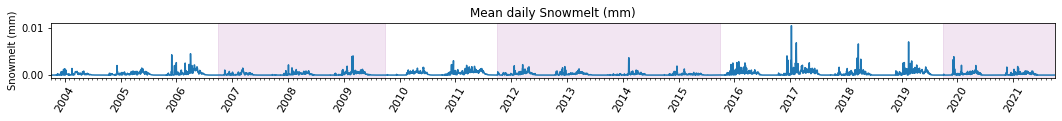

In [20]:
# Timeseries of PRCP / SMLT 

fig, ax = plt.subplots(figsize = (18,1))
ax.plot(dt_idx,list(smlt_arrs.values()))
ax.set_title("Mean daily Snowmelt (mm)")
ax.set_ylabel("Snowmelt (mm)")
ax.set_xlim(dt_idx[0],dt_idx[-1])

ax.set_xticklabels(ax.get_xticklabels(),rotation = 60, fontsize = 11)
ax.xaxis.set_major_locator(mdates.YearLocator())# Major ticks every year.
ax.xaxis.set_minor_locator(mdates.MonthLocator()) # Minor ticks every month.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))# Text in the x axis will be displayed in 'YYYY' format.

# ax.set(xticklabels=[])  # remove the tick labels

plt.axvspan('2006-10-01', '2009-10-01', alpha=0.1, color='purple', label = 'drought periods')
plt.axvspan('2011-10-01', '2015-10-01', alpha=0.1, color='purple')
plt.axvspan('2019-10-01', '2021-10-01', alpha=0.1, color='purple')
plt.title("Mean daily Snowmelt (mm)")

# plt.legend(bbox_to_anchor=[1, 1], loc='upper right')
plt.show()

<ipython-input-21-0d346b81ac66>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 60, fontsize = 11)


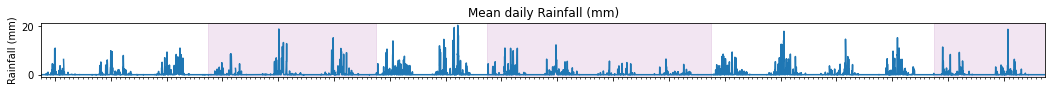

In [21]:
# Timeseries of PRCP 

fig, ax = plt.subplots(figsize = (18,1))
ax.plot(dt_idx,list(prcp_arrs.values()))
ax.set_title("Mean daily Liquid Precip (mm)")
ax.set_ylabel("Rainfall (mm)")
ax.set_xlim(dt_idx[0],dt_idx[-1])

ax.set_xticklabels(ax.get_xticklabels(),rotation = 60, fontsize = 11)
ax.xaxis.set_major_locator(mdates.YearLocator())# Major ticks every year.
ax.xaxis.set_minor_locator(mdates.MonthLocator()) # Minor ticks every month.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))# Text in the x axis will be displayed in 'YYYY' format.

ax.set(xticklabels=[])  # remove the tick labels

plt.axvspan('2006-10-01', '2009-10-01', alpha=0.1, color='purple', label = 'drought periods')
plt.axvspan('2011-10-01', '2015-10-01', alpha=0.1, color='purple')
plt.axvspan('2019-10-01', '2021-10-01', alpha=0.1, color='purple')
plt.title("Mean daily Rainfall (mm)")
# plt.legend(bbox_to_anchor=[1, 1], loc='upper right')
plt.show()